In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

## Simulate Data and Conditional Entropy Prediction

In [2]:
def generate_data(n, d, frac_eval, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(-1, n - n_1)))
  
    return X, y

def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

In [3]:
def conditional_entropy_distribution(n, d, frac_eval, algos, num_trials, mu, parallel = False):
    # For each trial, generate data and compute conditional entropy for each algorithm.
    def worker(t):
        # X, y, X_eval = generate_data(n, d, frac_eval, mu = mu)
        X, y = generate_data(n, d, 0, mu = mu)
        ret = np.zeros(len(algos))
        for i in range(len(algos)):
            obj = algos[i]['instance']
            if algos[i]['label'] == 'UF':
                obj.fit(X, y)
                ret[i] = obj.estimate_cond_entropy()
            else:
                X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
                obj.fit(X, y)
                p = obj.predict_proba(X_eval)
                ret[i] = np.mean(entropy(p.T, base = 2))
        return ret
    
    if parallel:
        predicted_cond_entropy = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_cond_entropy = np.zeros((num_trials, len(algos)))
        for t in tqdm(range(num_trials)):
            predicted_cond_entropy[t, :] = worker(t)
            
    return predicted_cond_entropy

## Compute True Conditional Entropy

In [4]:
def true_cond_entropy(mu):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log2(p)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0/np.log(2.0) + np.log2(2 * np.pi))
    H_Y = 1
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [5]:
def conditional_entropy_by_n(sample_sizes, d, frac_eval, algos, num_trials, mu, parallel = False):
    # Repeat for all 'n', and save output in the 'algos' array.
    cond_entropy_range = np.zeros((len(sample_sizes), num_trials, len(algos)))
    for i in range(len(sample_sizes)):
        cond_entropy_range[i, :, :] = conditional_entropy_distribution(sample_sizes[i], 
                                                                       d, 
                                                                       frac_eval, 
                                                                       algos, 
                                                                       num_trials, 
                                                                       mu = mu,
                                                                       parallel = parallel)
        
    for j in range(len(algos)):
        algos[j]['cond_entropy_by_n_d_%d' % d] = cond_entropy_range[:, :, j]
        
    with open('algos_fig2.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('sample_sizes_d_%d.pkl' % d, 'wb') as f:
        pickle.dump(sample_sizes, f)

In [6]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu):
    with open('sample_sizes_d_%d.pkl' % d, 'rb') as f:
        sample_sizes = pickle.load(f)
    with open('algos_fig2.pkl', 'rb') as f:
        algos = pickle.load(f)
    
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(algo['cond_entropy_by_n_d_%d' % d], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    algo['cond_entropy_by_n_d_%d' % d][:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, d = %d" % (mu, d))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [7]:
def conditional_entropy_by_mu(mus, n, d, frac_eval, algos, num_trials, parallel = False):
    # Repeat for all 'mu', and save output in the 'algos' array.
    cond_entropy_range = np.zeros((len(mus), num_trials, len(algos)))
    for i in range(len(mus)):
        cond_entropy_range[i, :, :] = conditional_entropy_distribution(n, 
                                                                       d, 
                                                                       frac_eval, 
                                                                       algos, 
                                                                       num_trials, 
                                                                       mu = mus[i],
                                                                       parallel = parallel)      
    for j in range(len(algos)):
        algos[j]['cond_entropy_by_mu_d_%d' % d] = cond_entropy_range[:, :, j]
        
    with open('algos_fig2.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('mus_fig2.pkl', 'wb') as f:
        pickle.dump(mus, f)

In [8]:
def plot_cond_entropy_by_mu(ax, d, n):
    with open('mus_fig2.pkl', 'rb') as f:
        mus = pickle.load(f)
    with open('algos_fig2.pkl', 'rb') as f:
        algos = pickle.load(f)
        
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(mus, 
                np.mean(algo['cond_entropy_by_mu_d_%d' % d], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.set_ylim(ymin = -.05)
    ax.set_title("n = %d, d = %d" % (n, d))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [9]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size)
    plot_cond_entropy_by_n(axes[0, 1], num_plotted_trials, d2, effect_size)
                                                  
    plot_cond_entropy_by_mu(axes[1, 0], d1, n1)
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2)
    
    axes[0,0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig2.pdf")
    plt.show()

## Run Experiments and Plot

In [10]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
frac_eval = 0.3
n_estimators = 300
effect_size = 2
d1 = 1
d2 = 40
n1 = 6000
n2 = 10000
num_trials_n = 50
num_trials_mu = 25
sample_sizes_d1 = range(100, 2501, 300)
sample_sizes_d2 = range(100, 10001, 990)

# Algorithms.
algos = [
    {
        'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 10
parallel = True

### Estimated H(Y | X) versus n, d = 1

In [11]:
# Estimate conditional entropy vs n.
conditional_entropy_by_n(sample_sizes_d1, d1, frac_eval, algos, num_trials_n, effect_size, parallel = parallel)
print(algos[0]['cond_entropy_by_n_d_%d' % d1])

[[0.0311356  0.02406427 0.02032801 0.00954657 0.10295337 0.00954657
  0.01563319 0.03126637 0.00954657 0.        ]
 [0.04142031 0.         0.08961347 0.         0.01694001 0.03750796
  0.04610887 0.05993533 0.00795547 0.01302766]
 [0.04332389 0.0803571  0.04914107 0.         0.01931615 0.01798554
  0.         0.00681898 0.01363795 0.11711081]]


### Estimated H(Y | X) versus mu, d = 1

In [12]:
# Estimate conditional entropy vs mu.
conditional_entropy_by_mu(mus, n1, d1, frac_eval, algos, num_trials_mu, parallel = parallel)
print(algos[0]['cond_entropy_by_mu_d_%d' % d1])

[[0.55371836 0.43877862 0.47636727 0.52141438 0.36484391 0.41481636
  0.53759651 0.75327038 0.53008377 0.48586583]
 [0.14321072 0.2883364  0.21919484 0.20446648 0.29334995 0.31257436
  0.27948361 0.2596813  0.2755022  0.31288191]
 [0.14424496 0.14969771 0.07628663 0.08109069 0.05145815 0.05270397
  0.07600912 0.05851427 0.22147956 0.24866743]
 [0.         0.         0.07178616 0.06065344 0.14156972 0.
  0.09340681 0.02032801 0.07790439 0.        ]
 [0.         0.02032801 0.02987458 0.         0.         0.07278994
  0.         0.         0.         0.        ]
 [0.01563319 0.         0.         0.         0.         0.
  0.         0.         0.         0.02406427]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00954657 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0. 

In [13]:
# Estimate conditional entropy vs n.
conditional_entropy_by_n(sample_sizes_d2, d2, frac_eval, algos, num_trials_n, effect_size, parallel = parallel)
print(algos[0]['cond_entropy_by_n_d_%d' % d2])

[[0.56294389 0.35732527 0.56507139 0.46201307 0.47418819 0.38230897
  0.62260941 0.38171037 0.49180698 0.42174475]
 [0.30974786 0.60678189 0.34970623 0.46669295 0.45964361 0.46098679
  0.33629825 0.31829227 0.2273349  0.29991071]
 [0.32042541 0.16246776 0.37775919 0.40065134 0.23942235 0.47088368
  0.38884222 0.35979868 0.35010716 0.26962716]]


In [14]:
# Estimate conditional entropy vs mu.
conditional_entropy_by_mu(mus, n2, d2, frac_eval, algos, num_trials_mu, parallel = parallel)
print(algos[0]['cond_entropy_by_mu_d_%d' % d2])

[[0.78151535 0.79127707 0.73268865 0.7477128  0.75869744 0.74377607
  0.78864275 0.7463482  0.74222112 0.7664636 ]
 [0.49341943 0.48825619 0.50354881 0.45329409 0.50952495 0.48382444
  0.4923435  0.48581736 0.46666191 0.43095145]
 [0.28193881 0.22998373 0.2761226  0.23890354 0.26697151 0.24975928
  0.26670758 0.24421272 0.22444519 0.26211154]
 [0.09264324 0.12553426 0.14829067 0.12012788 0.14882999 0.24212621
  0.12747552 0.13827538 0.1993726  0.17711167]
 [0.06971173 0.13790974 0.11657329 0.10416902 0.1063146  0.0986568
  0.14276671 0.10245701 0.1224387  0.13660368]
 [0.05634061 0.07360457 0.07206679 0.105226   0.07578218 0.14244814
  0.06654721 0.13363005 0.08774561 0.10950113]
 [0.06741592 0.05666773 0.03784027 0.06316363 0.0699339  0.08971918
  0.1168071  0.12011747 0.09317987 0.10178224]
 [0.10432616 0.13056383 0.01874714 0.07182768 0.07131487 0.07580812
  0.07087602 0.10319591 0.05624535 0.14469693]
 [0.01744649 0.08946904 0.08623583 0.09127933 0.05442811 0.04924123
  0.1652654  

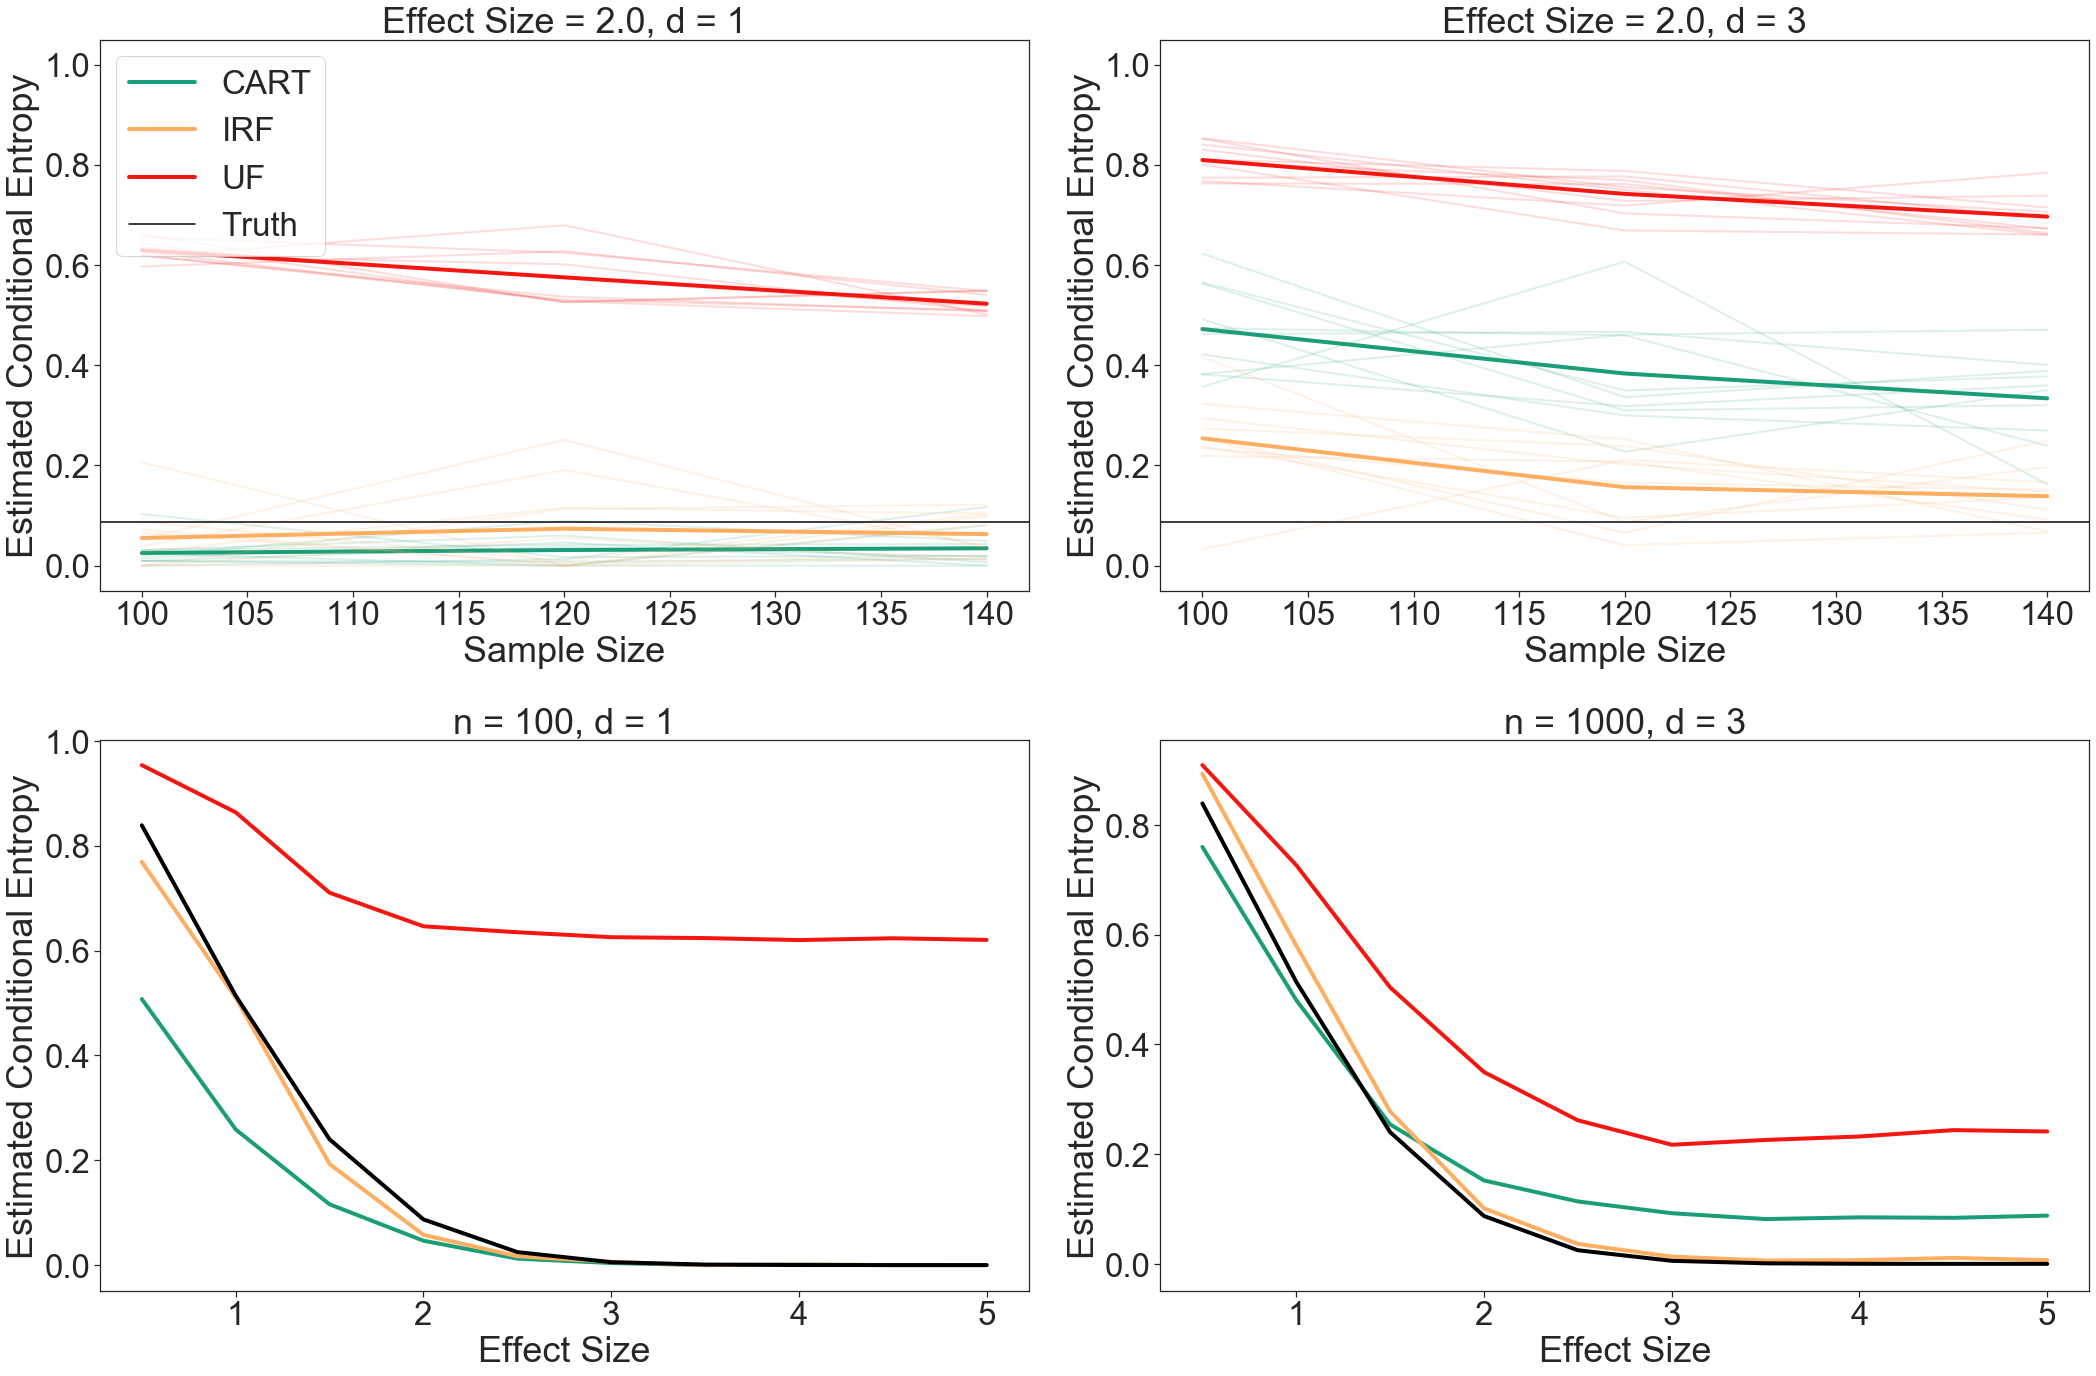

In [15]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size)